#1. Cloning the branch

In [1]:
!git clone https://github.com/vedpd/USD-MS-AAI.git
%cd USD-MS-AAI/Module\ 2
!git checkout module2-ved


Cloning into 'USD-MS-AAI'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 99 (delta 27), reused 58 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 11.61 MiB | 11.19 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/USD-MS-AAI/Module 2
Branch 'module2-ved' set up to track remote branch 'module2-ved' from 'origin'.
Switched to a new branch 'module2-ved'


In [2]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


#2. Library import

In [3]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, SpatialDropout1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import keras_tuner as kt
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import classification_report, f1_score
import keras_tuner as kt

In [22]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

#3. Data load

In [23]:
# Load your dataset
symptom_df2 = pd.read_csv("/content/USD-MS-AAI/Module 2/Data/Train_data.csv")

symptom_df2.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [24]:
symptom_df2.columns

Index(['Unnamed: 0', 'label', 'text'], dtype='object')

#4. Data Clean up

In [25]:
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text.strip()

In [26]:
# Apply cleaning - replace 'text_column' with the actual text feature name
symptom_df2['cleaned_text'] = symptom_df2['text'].apply(clean_text)

In [27]:
symptom_df2.head()

,Unnamed: 0,label,text,cleaned_text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...,i have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne...",my skin has been peeling especially on my knee...
2,2,Psoriasis,I have been experiencing joint pain in my fing...,i have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp...",there is a silver like dusting on my skin espe...
4,4,Psoriasis,"My nails have small dents or pits in them, and...",my nails have small dents or pits in them and ...


#5. Tokenization

In [28]:
# Tokenization
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(symptom_df2['cleaned_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [29]:
# Convert to sequences
max_len = 100
X = tokenizer.texts_to_sequences(symptom_df2['cleaned_text'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

# Label encoding
y = symptom_df2['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)
num_classes = y_onehot.shape[1]


#6. Train test split

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_encoded)

# Save vocab_size and num_classes for later use
print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Sample encoded text: {X_train[0]}")
print(f"Encoded label: {y_train[0]}")

Vocabulary size: 1584
Number of classes: 24
Sample encoded text: [ 23  29  19 291   2 321  23 201 502 269  21 735 182   8 381  91  22   3
  93   2  79   4   7  68   3  83   2  28  80 232 183   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
Encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Train class distribution:
Class 0: 40
Class 1: 40
Class 2: 40
Class 3: 40
Class 4: 40
Class 5: 40
Class 6: 40
Class 7: 40
Class 8: 40
Class 9: 40
Class 10: 40
Class 11: 40
Class 12: 40
Class 13: 40
Class 14: 40
Class 15: 40
Class 16: 40
Class 17: 40
Class 18: 40
Class 19: 40
Class 20: 40
Class 21: 40
Class 22: 40
Class 23: 40

Test class distribution:
Class 0: 10
Class 1: 10
Class 2: 10
Class 3: 10
Class 4: 10
Class 5: 10
Class 6: 10
Class 7: 10
Class 8: 10
Class 9: 10
Class 10: 10
Class 11: 10
Class 12: 10
Class 13: 10
Class 14: 10
Class 15: 10
Class 16: 10
Class 17: 10
Class 18: 10
Class 19: 10
Class 20: 10
Class 21: 10
Class 22: 10
Class 23: 10


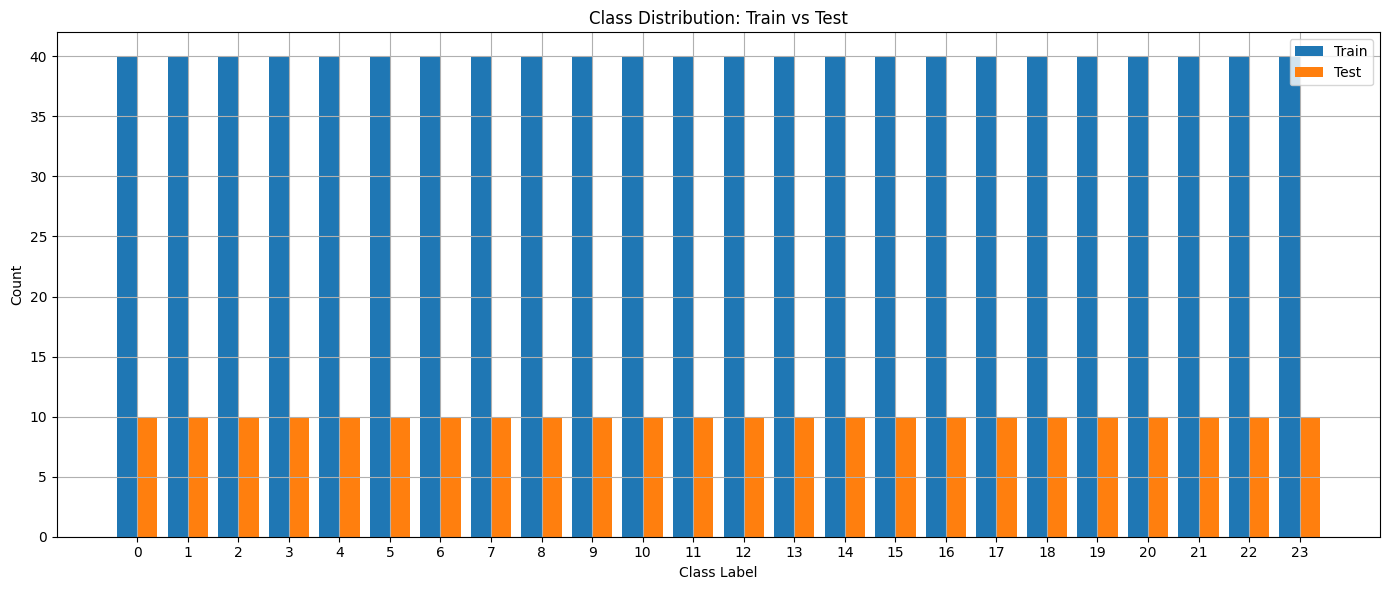

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Convert one-hot back to integer labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Count class distribution
train_counts = Counter(y_train_labels)
test_counts = Counter(y_test_labels)

# Sort by class index
train_counts = dict(sorted(train_counts.items()))
test_counts = dict(sorted(test_counts.items()))

# Print distribution
print("Train class distribution:")
for label, count in train_counts.items():
    print(f"Class {label}: {count}")

print("\nTest class distribution:")
for label, count in test_counts.items():
    print(f"Class {label}: {count}")

# Plot the distributions
plt.figure(figsize=(14, 6))
width = 0.4
classes = list(train_counts.keys())
train_vals = list(train_counts.values())
test_vals = list(test_counts.values())

x = np.arange(len(classes))
plt.bar(x - width/2, train_vals, width, label='Train')
plt.bar(x + width/2, test_vals, width, label='Test')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution: Train vs Test')
plt.xticks(ticks=x, labels=classes)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#7. Hybrid model

In [32]:
#Step 2: Build LSTM-GRU Hybrid Model
embedding_dim = 128

inputs = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)
x = SpatialDropout1D(0.3)(x)

# LSTM and GRU branches
lstm_out = LSTM(64, return_sequences=True)(x)
gru_out = GRU(64, return_sequences=True)(x)

# Concatenate both branches
x = Concatenate()([lstm_out, gru_out])
x = GlobalMaxPooling1D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 128)  │    202,752 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 100, 128)  │          0 │ embedding_2[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 100, 64)   │     49,408 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 100, 64)   │     37,248 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100, 128)  │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ concatenate_2[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ global_max_pooli… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 24)        │      3,096 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 309,528 (1.18 MB)

 Trainable params: 309,272 (1.18 MB)

 Non-trainable params: 256 (1.00 KB)

#8. Model training

In [33]:
# Step 3: Training callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]


In [34]:
# Step 4: Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=15,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.0671 - loss: 3.1644

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.0679 - loss: 3.1613 - val_accuracy: 0.1354 - val_loss: 3.1603 - learning_rate: 0.0010
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3123 - loss: 2.6882

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.3154 - loss: 2.6822 - val_accuracy: 0.3542 - val_loss: 3.0996 - learning_rate: 0.0010
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6017 - loss: 1.8670

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6027 - loss: 1.8605 - val_accuracy: 0.4375 - val_loss: 2.9548 - learning_rate: 0.0010
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7372 - loss: 1.1596

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7385 - loss: 1.1542 - val_accuracy: 0.5104 - val_loss: 2.7803 - learning_rate: 0.0010
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8559 - loss: 0.6734

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.8565 - loss: 0.6706 - val_accuracy: 0.5625 - val_loss: 2.5843 - learning_rate: 0.0010
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9111 - loss: 0.4026

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9118 - loss: 0.4009 - val_accuracy: 0.7812 - val_loss: 2.3440 - learning_rate: 0.0010
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9577 - loss: 0.2490

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9580 - loss: 0.2479 - val_accuracy: 0.8542 - val_loss: 2.0987 - learning_rate: 0.0010
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9718 - loss: 0.1534

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9719 - loss: 0.1530 - val_accuracy: 0.9479 - val_loss: 1.8479 - learning_rate: 0.0010
Epoch 9/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9898 - loss: 0.1149

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9899 - loss: 0.1145 - val_accuracy: 0.9792 - val_loss: 1.6025 - learning_rate: 0.0010
Epoch 10/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9932 - loss: 0.0767

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.9932 - loss: 0.0765 - val_accuracy: 0.9792 - val_loss: 1.3330 - learning_rate: 0.0010
Epoch 11/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9885 - loss: 0.0737

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9886 - loss: 0.0733 - val_accuracy: 0.9688 - val_loss: 1.1546 - learning_rate: 0.0010
Epoch 12/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9990 - loss: 0.0396

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9989 - loss: 0.0397 - val_accuracy: 0.9688 - val_loss: 0.8806 - learning_rate: 0.0010
Epoch 13/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9967 - loss: 0.0377

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.9967 - loss: 0.0376 - val_accuracy: 0.9688 - val_loss: 0.6887 - learning_rate: 0.0010
Epoch 14/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9986 - loss: 0.0356

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9985 - loss: 0.0356 - val_accuracy: 0.9792 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 15/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0272

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9999 - loss: 0.0272 - val_accuracy: 0.9792 - val_loss: 0.3695 - learning_rate: 0.0010


#9. Model Evaluation

In [35]:
# Step 5: Evaluate model
y_pred = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

Classification Report:

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       1.00      0.90      0.95        10
                    Common Cold       1.00      1.00      1.00        10
                         Dengue       0.83      1.00      0.91        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       1.00      1.00      1.00        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       0.91      1.00      0.95        10
                       Jaundice       1.00      1.00      1.

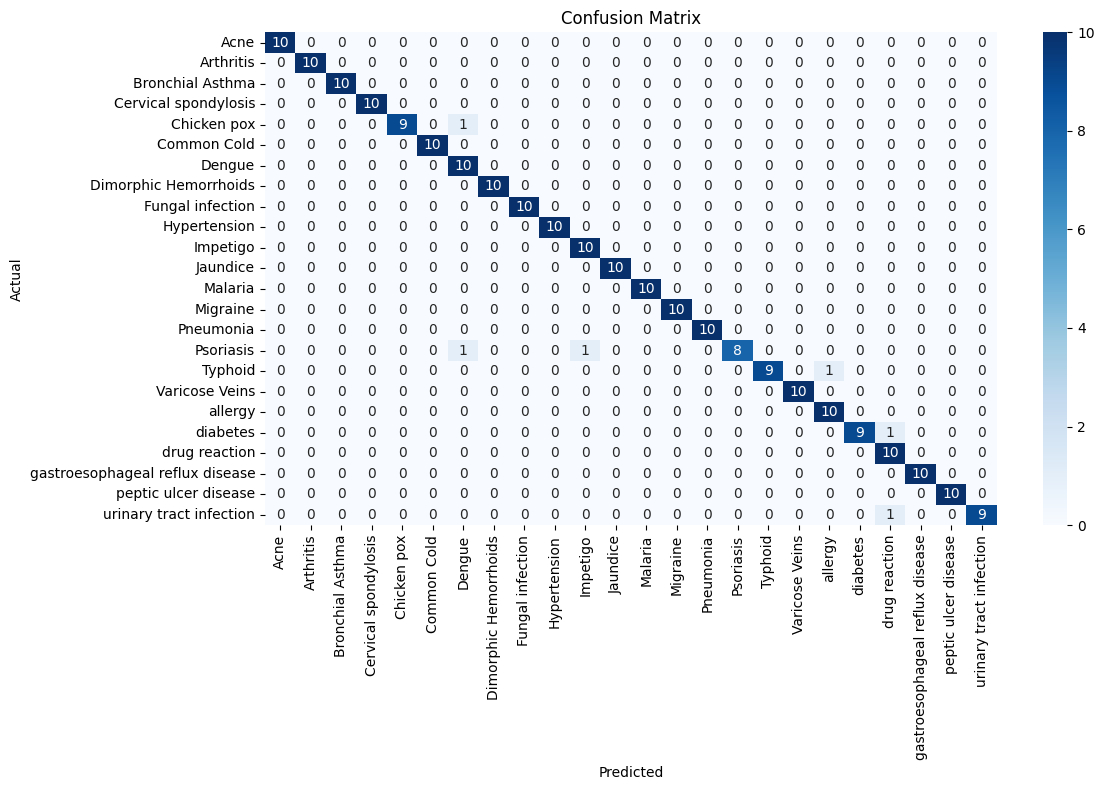

In [36]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [37]:
from sklearn.metrics import f1_score

# Predictions for training data
y_train_pred = model.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train, axis=1)  # if y_train is one-hot

# Predictions for test data
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)  # if y_test is one-hot

# Calculate F1 macro scores
train_f1_macro = f1_score(y_train_true_classes, y_train_pred_classes, average='macro')
test_f1_macro = f1_score(y_test_true_classes, y_test_pred_classes, average='macro')

print(f"Train F1 Macro Score: {train_f1_macro:.4f}")
print(f"Test F1 Macro Score: {test_f1_macro:.4f}")

# Calculate F1 weighted scores
train_f1_weighted = f1_score(y_train_true_classes, y_train_pred_classes, average='weighted')
test_f1_weighted = f1_score(y_test_true_classes, y_test_pred_classes, average='weighted')

print(f"Train F1 weighted Score: {train_f1_weighted:.4f}")
print(f"Test F1 weighted Score: {test_f1_weighted:.4f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Train F1 Macro Score: 0.9979
Test F1 Macro Score: 0.9751
Train F1 weighted Score: 0.9979
Test F1 weighted Score: 0.9751


In [38]:
# Macro F1 Score
from sklearn.metrics import f1_score, confusion_matrix

f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro')
print(f"\nMacro F1 Score: {f1_macro:.4f}")


Macro F1 Score: 0.9751


In [39]:

# performance in test
from sklearn.metrics import f1_score

# Assuming y_test_labels and y_pred_labels are defined
macro_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')
weighted_f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Macro F1 Score: 0.9751
Weighted F1 Score: 0.9751


In [40]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(y_true, y_pred, class_labels=None):
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    print("Accuracy Score:", accuracy_score(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC AUC per class (One-vs-Rest)
    try:
        y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))
        y_pred_bin = label_binarize(y_pred, classes=np.arange(len(class_labels)))
        roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro", multi_class="ovr")
        print("Macro ROC AUC Score (OvR):", roc_auc)
    except Exception as e:
        print("ROC AUC not computed (likely due to single label predictions):", e)


Classification Report:

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       1.00      0.90      0.95        10
                    Common Cold       1.00      1.00      1.00        10
                         Dengue       0.83      1.00      0.91        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       1.00      1.00      1.00        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       0.91      1.00      0.95        10
                       Jaundice       1.00      1.00      1.00        10
                        Ma

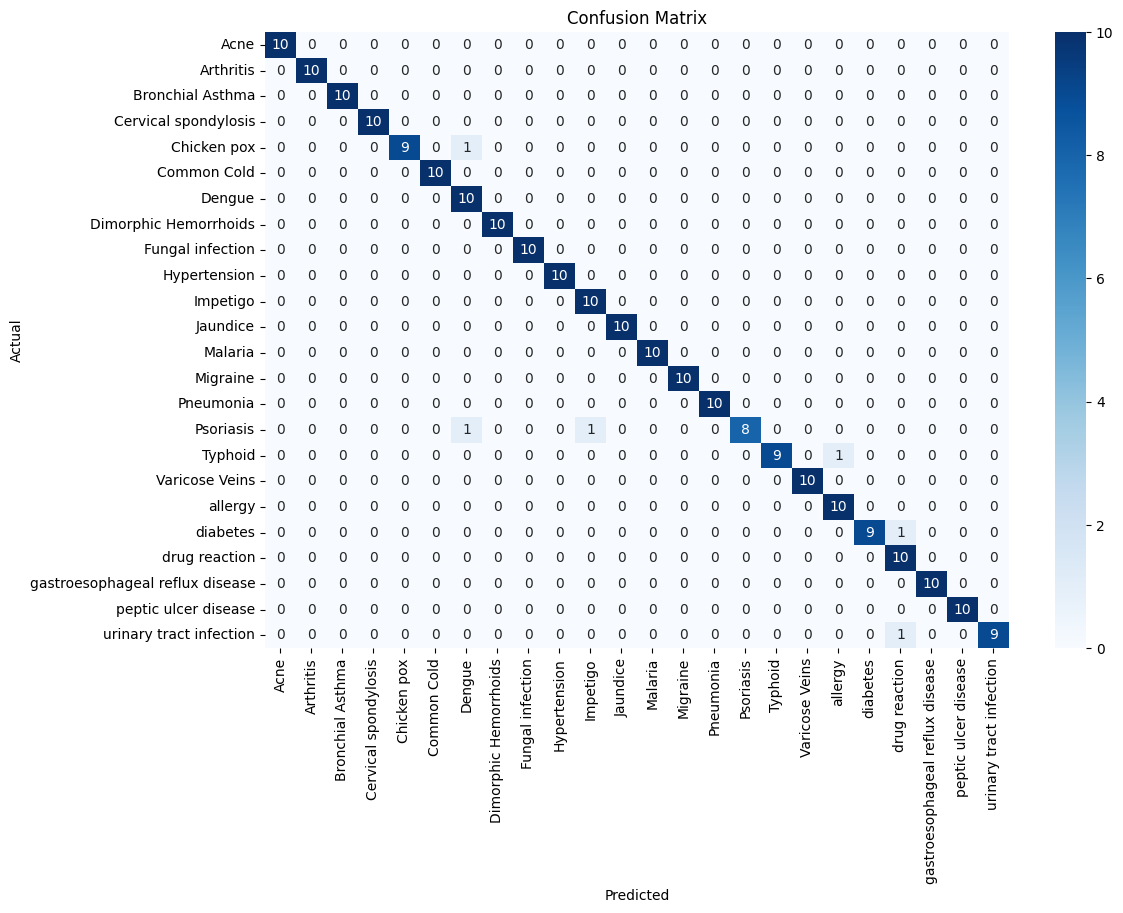

Macro ROC AUC Score (OvR): 0.9869565217391304


In [41]:
evaluate_model(y_test_labels, y_pred_labels, class_labels=label_encoder.classes_)


## Committing code from colab to branch

In [43]:
!git config --global user.email "ved.30dec@example.com"
!git config --global user.name "vedpd"


In [44]:
# 2️⃣ Make sure you're in the repo's root directory
%cd "/content/USD-MS-AAI"


/content/USD-MS-AAI


In [45]:
# Stage the changes
!git add "Module 2/modelling/Improved_Symptom_Classifier_LSTM_GRU.ipynb"

# Commit
!git commit -m "Updated Improved_Symptom_Classifier_LSTM_GRU.ipynb"

# Push to the branch
!git push origin module2-ved


fatal: pathspec 'Module 2/modelling/Improved_Symptom_Classifier_LSTM_GRU.ipynb' did not match any files
On branch module2-ved
Your branch is up to date with 'origin/module2-ved'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Module 2/best_model.h5

nothing added to commit but untracked files present (use "git add" to track)
fatal: could not read Username for 'https://github.com': No such device or address


# 10. Model saving

In [ ]:
# Save final model in .h5 format
model.save("final_symptom_classifier.h5")


In [ ]:
# After training
model.save("final_symptom_classifier.keras", save_format="keras")


In [ ]:
import pickle

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [ ]:
!pip freeze > requirements.txt


In [ ]:

import pickle

# Get label names from label encoder
label_names = list(label_encoder.classes_)

# Create label map dictionary
label_map = {label: idx for idx, label in enumerate(label_names)}

# Save to pickle
with open("label_map.pkl", "wb") as f:
    pickle.dump(label_map, f)

print("label_map.pkl saved.")


In [ ]:
# Save tokenizer
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(tokenizer_json)
